In [1]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
# load image data

data = []
file_list = []
y = []

for png in os.listdir("../data/CT_COVID"):
    pic = plt.imread("../data/CT_COVID/" + png, 0)
    data.append(pic)
    file_list.append(png)
    y.append(1)

for png in os.listdir("../data/CT_NonCOVID"):
    pic = plt.imread("../data/CT_NonCOVID/" + png, 0)
    data.append(pic)
    file_list.append(png)
    y.append(0)

In [3]:
metadata = pd.read_excel("../data/COVID-CT-MetaInfo.xlsx", header = None, names = ['file','patient','column3','note'])

Case and Control Counts: 
Case
0    397
1    333
Name: Case, dtype: int64


Example Image with COVID: 


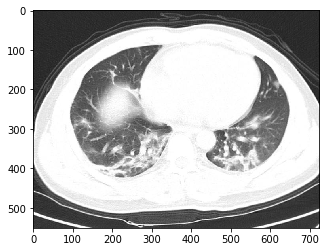

Example Image without COVID: 


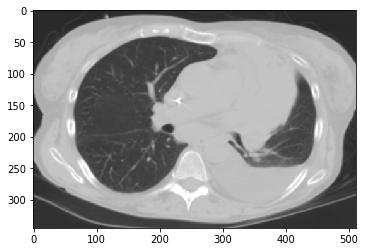

In [4]:
print("Case and Control Counts: ")
print(pd.DataFrame(y, columns = ['Case']).groupby("Case").Case.count())

print("\n")

print("Example Image with COVID: ")
plt.imshow(data[1]); plt.show();

print("Example Image without COVID: ")
plt.imshow(data[501], cmap = 'gray'); plt.show();

In [4]:
image_dim = (300, 400) #use the averages for the dimensions

data_cleaned = []

for img in data:
    #First, take the mean of the 3rd dimension (channels) if it exists
    if len(img.shape) == 3:
        img = np.mean(img, axis = 2)
    
    #Using PIL Image processor, resize using high quality down-sampling filter 
    img = Image.fromarray(img)
    img = img.resize((image_dim[1], image_dim[0]), Image.ANTIALIAS)
    img = np.array(img)
    
    #Normalize image values
    img = img/255
    
    data_cleaned.append(img)

data_cleaned = np.array(data_cleaned)
data_cleaned = np.expand_dims(data_cleaned,axis = 3)

In [5]:
data_train, data_val, y_train, y_val = train_test_split(data_cleaned, np.array(y),\
                                                        train_size = 0.75, random_state = 10)

In [6]:
#Flip horizontally
horiz_flip = tf.image.flip_left_right(data_train) 
#Flip vertically
vert_flip = tf.image.flip_up_down(data_train)

data_train_augmented = np.concatenate((data_train, horiz_flip, vert_flip), axis = 0)
y_train_augmented = np.concatenate((y_train,y_train,y_train), axis = 0)

In [ ]:
rgb_batch = np.repeat(grayscale_batch[..., np.newaxis], 3, -1)
print(rgb_batch.shape)  # (64, 224, 224, 3)



In [9]:
np.repeat(data_cleaned.reshape((-1,300,400))[..., np.newaxis], 3, -1)

array([[[[0.89517641, 0.89517641, 0.89517641],
         [0.91346055, 0.91346055, 0.91346055],
         [0.9347887 , 0.9347887 , 0.9347887 ],
         ...,
         [0.80183339, 0.80183339, 0.80183339],
         [0.8027181 , 0.8027181 , 0.8027181 ],
         [0.80077648, 0.80077648, 0.80077648]],

        [[0.89992797, 0.89992797, 0.89992797],
         [0.90665603, 0.90665603, 0.90665603],
         [0.90596205, 0.90596205, 0.90596205],
         ...,
         [0.80025381, 0.80025381, 0.80025381],
         [0.8050915 , 0.8050915 , 0.8050915 ],
         [0.8022334 , 0.8022334 , 0.8022334 ]],

        [[0.88348746, 0.88348746, 0.88348746],
         [0.87019253, 0.87019253, 0.87019253],
         [0.85839295, 0.85839295, 0.85839295],
         ...,
         [0.81009424, 0.81009424, 0.81009424],
         [0.81762302, 0.81762302, 0.81762302],
         [0.81100971, 0.81100971, 0.81100971]],

        ...,

        [[0.87180716, 0.87180716, 0.87180716],
         [0.87968403, 0.87968403, 0.87968403]

In [13]:
#img_input = Input(shape=(300, 400, 1))
model = VGG16(weights="imagenet", input_tensor=Input(shape=(300, 400, 3)))

ResourceExhaustedError: OOM when allocating tensor with shape[55296,4096] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:RandomUniform]

In [13]:

yhat = model.predict(data_cleaned[0].reshape(-1,300,400,1))

In [14]:
from tensorflow.keras.applications.vgg16 import decode_predictions
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

Using TensorFlow backend.


ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1, 9, 12, 512)

In [41]:
model.summary()

Model: "vgg16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 300, 400, 1) 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 300, 400, 3)  0           input_11[0][0]                   
                                                                 input_11[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 300, 400, 64) 1792        concatenate_1[0][0]              
______________________________________________________________________________________________